#### Overview
This time this code evaluates the performance of the inline filetring with range filtering. It uses HNSW while applying numerical range filters.

#### Key Metrics

Query Latency: Measures search time with/without range filters
Accuracy: Evaluates Recall@k for filtered vs unfiltered searches
Filter Performance: Analyzes impact of range specificity on search quality

#### Features

Supports both uniform and skewed data distributions
Tests multiple range filter configurations (single label, two labels, all labels)
Comprehensive visualization of performance metrics
Memory usage tracking and throughput analysis

#### Imports


In [1]:
import hnswlib
import numpy as np
import time
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import psutil
import os
from scipy import stats
import psutil
import os

     


In [2]:
class LabelFilteredANNEvaluator:
    """
    Design Metrics for Range-Filtered ANN Search:
    1. Query Latency:
       - Measures search time with/without filters
       - Compares overhead of range filtering
    2. Accuracy Impact:
       - Recall@k: proportion of true nearest neighbors found
       - How range filtering affects quality of results
    3. Filter Friction:
       - Range specificity: proportion of points passing filter
       - Impact of numerical distribution on performance
    """
    def __init__(self, dim=16, num_elements=3000):
        self.dim = dim
        self.num_elements = num_elements
        self.metrics = defaultdict(list)

    def generate_uniform_labeled_data(self):
        """Generate uniform data with three numerical labels distributed equally"""
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
        
        num_per_label = self.num_elements // 3
        self.labels = np.array([0] * num_per_label + 
                             [1] * num_per_label + 
                             [2] * (self.num_elements - 2 * num_per_label))
        p = np.random.permutation(len(self.data))
        self.data = self.data[p]
        self.labels = self.labels[p]
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
        return self.data, self.labels

    def generate_skewed_labeled_data(self):
        """Generate skewed data with three numerical labels distributed as 60%, 30%, 10%"""
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
    
        label_0_count = int(self.num_elements * 0.6)  # 60%
        label_1_count = int(self.num_elements * 0.3)  # 30%
        label_2_count = self.num_elements - label_0_count - label_1_count  # Remaining (10%)
    
        self.labels = np.array([0] * label_0_count + 
                          [1] * label_1_count + 
                          [2] * label_2_count)
    
        p = np.random.permutation(len(self.data))
        self.data = self.data[p]
        self.labels = self.labels[p]
    
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
    
        return self.data, self.labels

    def build_index(self):
        """Build HNSW index with the generated data"""
        self.index = hnswlib.Index(space='cosine', dim=self.dim)
        self.index.init_index(max_elements=self.num_elements, ef_construction=100, M=16)
        self.index.set_ef(20)
        self.index.set_num_threads(1)
        start_time = time.time()
        self.index.add_items(self.data, ids=np.arange(self.num_elements))
        build_time = time.time() - start_time
        self.metrics['build_time'] = build_time

    def create_range_filter(self, min_val, max_val):
        """Create filter function for a specific numerical range"""
        def filter_function(idx):
            return min_val <= self.labels[idx] <= max_val
        return filter_function
    
    def calculate_recall(self, filtered_results, true_results, query_points, min_val, max_val, k):
        """
        Calculate recall@k for range-filtered nearest neighbor search results.
        
        Args:
            filtered_results: Results from filtered knn search (n_queries x k)
            true_results: Results from unfiltered knn search (n_queries x k)
            query_points: Query points used for search (n_queries x dim)
            min_val: Minimum value for range filter
            max_val: Maximum value for range filter
            k: Number of nearest neighbors
        
        Returns:
            float: Average recall@k across all queries
        """
        recall = 0
        n_queries = len(query_points)
    
        range_mask = (self.labels >= min_val) & (self.labels <= max_val)
        range_data = self.data[range_mask]
        range_indices = np.where(range_mask)[0]
    
        for i in range(n_queries):
            distances = np.linalg.norm(range_data - query_points[i], axis=1)
            true_neighbor_indices = range_indices[np.argsort(distances)[:k]]
        
            filtered_neighbor_indices = filtered_results[i]
        
            intersection = set(filtered_neighbor_indices) & set(true_neighbor_indices)
            recall += len(intersection) / k
    
        return recall / n_queries

    def calculate_range_specificity(self, min_val, max_val):
        """Calculate filter specificity for a given range"""
        filter_func = self.create_range_filter(min_val, max_val)
        points_passing_filter = sum(filter_func(i) for i in range(self.num_elements))
        return points_passing_filter / self.num_elements
    
    def calculate_memory_usage(self):
        """Calculate memory usage of the index and data structures"""

        
        process = psutil.Process(os.getpid())
        baseline_memory = process.memory_info().rss
        index_memory = self.index.get_max_elements() * self.dim * 4  # 4 bytes per float32
        total_memory = process.memory_info().rss
        
        return {
            'baseline_memory_mb': baseline_memory / (1024 * 1024),
            'index_memory_mb': index_memory / (1024 * 1024),
            'total_memory_mb': total_memory / (1024 * 1024)
        }

    def calculate_throughput(self, query_time, num_queries):
        """Calculate queries per second throughput"""
        return num_queries / query_time if query_time > 0 else 0

    def evaluate_comprehensive(self, ef_values=None, num_queries=100, k=10):
        """Comprehensive evaluation across different EF values and distributions"""
        if ef_values is None:
            ef_values = [10, 20, 50, 100, 200]
                
        distributions = {
            'uniform': self.generate_uniform_labeled_data,
            'skewed': self.generate_skewed_labeled_data
        }
        
        results = defaultdict(lambda: defaultdict(list))
        
        #  range filters to evaluate
        range_filters = [
            (0, 0),  # Single label
            (0, 1),  # Two labels
            (0, 2)   # All labels
        ]
        
        for dist_name, dist_func in distributions.items():
            print(f"\nEvaluating {dist_name} distribution...")
            
            dist_func()
            self.build_index()
            
            memory_metrics = self.calculate_memory_usage()
            results[dist_name]['memory_metrics'] = memory_metrics
            
            # Calculate  range specificities
            for min_val, max_val in range_filters:
                specificity = self.calculate_range_specificity(min_val, max_val)
                results[dist_name][f'specificity_{min_val}_{max_val}'] = specificity
            
            query_points = np.float32(np.random.random((num_queries, self.dim)))
            
            for ef in ef_values:
                print(f"Processing EF={ef}...")
                self.index.set_ef(ef)
                
                # Unfiltered baseline
                start_time = time.time()
                unfiltered_labels, _ = self.index.knn_query(query_points, k=k)
                unfiltered_time = time.time() - start_time
                
                throughput = self.calculate_throughput(unfiltered_time, num_queries)
                
                results[dist_name]['ef'].append(ef)
                results[dist_name]['unfiltered_latency'].append(unfiltered_time / num_queries)
                results[dist_name]['unfiltered_throughput'].append(throughput)
                
                # Evaluate each range filter
                for min_val, max_val in range_filters:
                    filter_func = self.create_range_filter(min_val, max_val)
                    
                    start_time = time.time()
                    filtered_labels, _ = self.index.knn_query(query_points, k=k, filter=filter_func)
                    filtered_time = time.time() - start_time
                    
                    recall = self.calculate_recall(filtered_labels, unfiltered_labels, 
                                                 query_points, min_val, max_val, k)
                    throughput = self.calculate_throughput(filtered_time, num_queries)
                    
                    # Store metrics
                    range_key = f'range_{min_val}_{max_val}'
                    results[dist_name][f'{range_key}_latency'].append(filtered_time / num_queries)
                    results[dist_name][f'{range_key}_recall'].append(recall)
                    results[dist_name][f'{range_key}_throughput'].append(throughput)

        return results

In [7]:
def plot_comprehensive_results(results, matched_points):
    """Plot comprehensive comparison graphs for range-filtered results"""
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 15))
    
    colors = {
        'range_0_0': 'blue',     # Single label
        'range_0_1': 'green',    # Two labels
        'range_0_2': 'red',      # All labels
        'unfiltered': 'black'
    }
    markers = {'uniform': 'o', 'skewed': 's'}
    
    dist_names = ['uniform', 'skewed']
    range_filters = ['range_0_0', 'range_0_1', 'range_0_2']
    
    # Plot 1: Recall vs EF
    for dist_name in dist_names:
        for range_key in range_filters:
            ax1.plot(results[dist_name]['ef'],
                    results[dist_name][f'{range_key}_recall'],
                    color=colors[range_key],
                    marker=markers[dist_name],
                    label=f'{range_key} ({dist_name})')
    
    ax1.set_title('Recall vs EF')
    ax1.set_xlabel('EF Value')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Throughput vs EF
    for dist_name in dist_names:
        for range_key in range_filters:
            ax2.plot(results[dist_name]['ef'],
                    results[dist_name][f'{range_key}_throughput'],
                    color=colors[range_key],
                    marker=markers[dist_name],
                    label=f'{range_key} ({dist_name})')
    
    ax2.set_title('Throughput vs EF')
    ax2.set_xlabel('EF Value')
    ax2.set_ylabel('Queries/second')
    ax2.grid(True)
    ax2.legend()

    # Plot 3: Recall-Latency curves
    for dist_name in dist_names:
        ax3.plot(results[dist_name]['unfiltered_latency'],
                [1.0] * len(results[dist_name]['unfiltered_latency']),
                color=colors['unfiltered'],
                marker=markers[dist_name],
                label=f'Unfiltered ({dist_name})')
        
        for range_key in range_filters:
            ax3.plot(results[dist_name][f'{range_key}_latency'],
                    results[dist_name][f'{range_key}_recall'],
                    color=colors[range_key],
                    marker=markers[dist_name],
                    label=f'{range_key} ({dist_name})')
    
    ax3.set_title('Recall vs Latency')
    ax3.set_xlabel('Latency (s)')
    ax3.set_ylabel('Recall')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: Matched Recall Points
    for dist_name in dist_names:
        for range_key in range_filters:
            points = matched_points[dist_name][range_key]
            recalls = [metrics['recall'] for _, metrics in points.items()]
            latencies = [metrics['latency'] for _, metrics in points.items()]
            
            ax4.scatter(recalls, latencies,
                       color=colors[range_key],
                       marker=markers[dist_name],
                       label=f'{range_key} ({dist_name})',
                       s=100)
    
    ax4.set_title('Matched Recall Points')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Latency (s)')
    ax4.grid(True)
    ax4.legend()
    
    # Plot 5: Filter Specificity vs Latency
    for dist_name in dist_names:
        specificities = []
        avg_latencies = []
        
        for range_key in range_filters:
            specificity = results[dist_name][f'specificity_{range_key[-3:]}']
            avg_latency = np.mean(results[dist_name][f'{range_key}_latency'])
            
            specificities.append(specificity)
            avg_latencies.append(avg_latency)
            
        ax5.plot(specificities, avg_latencies,
                color='blue' if dist_name == 'uniform' else 'red',
                marker=markers[dist_name],
                label=f'{dist_name}',
                linewidth=2)
    
    ax5.set_title('Filter Specificity vs Latency')
    ax5.set_xlabel('Filter Specificity')
    ax5.set_ylabel('Average Latency (s)')
    ax5.grid(True)
    ax5.legend()
    
    # Plot 6: Throughput vs Filter Specificity
    for dist_name in dist_names:
        specificities = []
        avg_throughput = []
        
        for range_key in range_filters:
            specificity = results[dist_name][f'specificity_{range_key[-3:]}']
            throughput = np.mean(results[dist_name][f'{range_key}_throughput'])
            
            specificities.append(specificity)
            avg_throughput.append(throughput)
            
        ax6.plot(specificities, avg_throughput,
                color='blue' if dist_name == 'uniform' else 'red',
                marker=markers[dist_name],
                label=f'{dist_name}',
                linewidth=2)
    
    ax6.set_title('Filter Specificity vs Throughput')
    ax6.set_xlabel('Filter Specificity')
    ax6.set_ylabel('Average Throughput (queries/s)')
    ax6.grid(True)
    ax6.legend()
    
    plt.tight_layout()
    return fig

Running comprehensive evaluation...

Evaluating uniform distribution...
Processing EF=10...
Processing EF=20...
Processing EF=50...
Processing EF=100...
Processing EF=200...

Evaluating skewed distribution...
Processing EF=10...
Processing EF=20...
Processing EF=50...
Processing EF=100...
Processing EF=200...

Generating comparison plots...

Detailed Summary Statistics:

Uniform Distribution Memory Usage:
- Baseline Memory: 29.09 MB
- Index Memory: 0.18 MB
- Total Memory: 29.12 MB

Unfiltered Search Performance:
EF values: [10, 20, 50, 100, 200]
- Throughput (queries/s): ['58457.2', '28844.7', '11175.3', '12648.3', '7774.9']
- Latency (ms): ['0.02', '0.03', '0.09', '0.08', '0.13']

Skewed Distribution Memory Usage:
- Baseline Memory: 30.43 MB
- Index Memory: 0.18 MB
- Total Memory: 30.43 MB

Unfiltered Search Performance:
EF values: [10, 20, 50, 100, 200]
- Throughput (queries/s): ['56390.2', '22472.7', '3684.9', '9960.6', '4480.4']
- Latency (ms): ['0.02', '0.04', '0.27', '0.10', '0.2

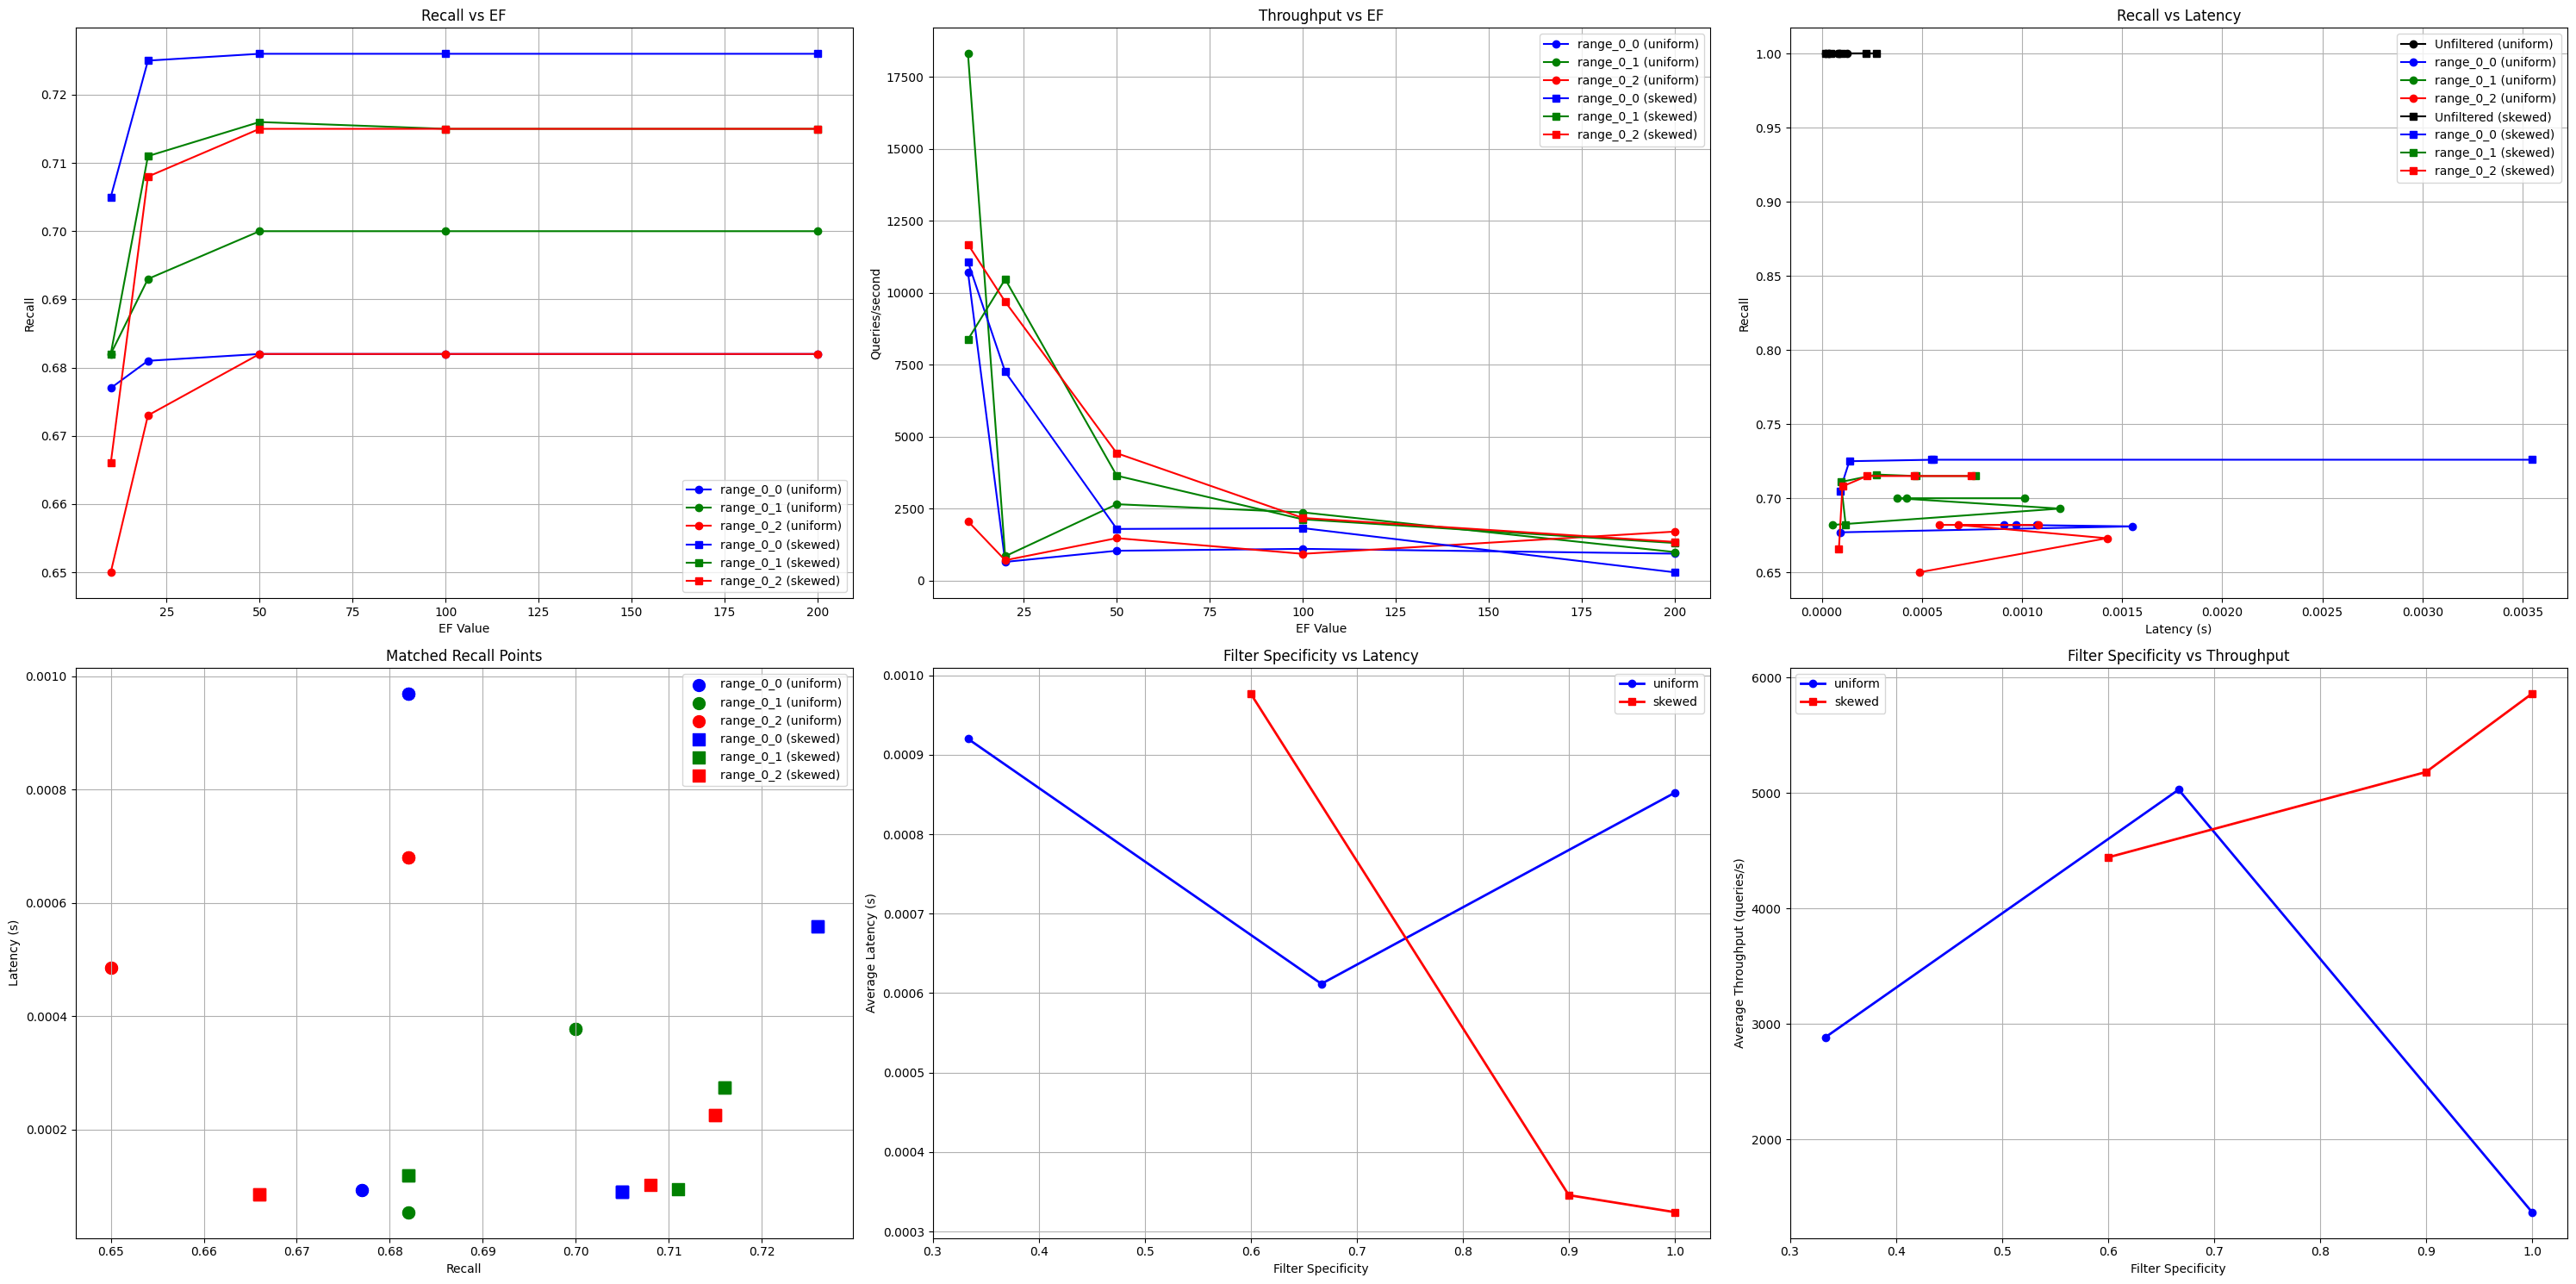

In [8]:
def match_recall_points(results, recall_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9]):
    """Find points with matching recall levels for range filters"""
    matched_points = defaultdict(lambda: defaultdict(dict))
    dist_names = ['uniform', 'skewed']
    range_filters = ['range_0_0', 'range_0_1', 'range_0_2']
    
    for dist_name in dist_names:
        for range_key in range_filters:
            recalls = results[dist_name][f'{range_key}_recall']
            latencies = results[dist_name][f'{range_key}_latency']
            
            if len(recalls) > 0:
                for threshold in recall_thresholds:
                    closest_idx = min(range(len(recalls)), 
                                    key=lambda i: abs(recalls[i] - threshold))
                    matched_points[dist_name][range_key][threshold] = {
                        'recall': recalls[closest_idx],
                        'latency': latencies[closest_idx],
                        'ef': results[dist_name]['ef'][closest_idx],
                        'throughput': results[dist_name][f'{range_key}_throughput'][closest_idx]
                    }
    
    return matched_points

def run_enhanced_comparison():
    """Run comprehensive comparison with range filter analyses"""
    evaluator = LabelFilteredANNEvaluator()
    ef_values = [10, 20, 50, 100, 200]
    
    print("Running comprehensive evaluation...")
    results = evaluator.evaluate_comprehensive(ef_values)
    
    print("\nGenerating comparison plots...")
    matched_points = match_recall_points(results)

    fig = plot_comprehensive_results(results, matched_points)    
    
    # Print detailed summary statistics
    print("\nDetailed Summary Statistics:")
    dist_names = ['uniform', 'skewed']
    range_filters = ['range_0_0', 'range_0_1', 'range_0_2']
    
    for dist_name in dist_names:
        print(f"\n{dist_name.capitalize()} Distribution Memory Usage:")
        memory_metrics = results[dist_name]['memory_metrics']
        print(f"- Baseline Memory: {memory_metrics['baseline_memory_mb']:.2f} MB")
        print(f"- Index Memory: {memory_metrics['index_memory_mb']:.2f} MB")
        print(f"- Total Memory: {memory_metrics['total_memory_mb']:.2f} MB")
        
        print(f"\nUnfiltered Search Performance:")
        print("EF values:", results[dist_name]['ef'])
        print(f"- Throughput (queries/s):", 
              [f"{v:.1f}" for v in results[dist_name]['unfiltered_throughput']])
        print(f"- Latency (ms):", 
              [f"{v*1000:.2f}" for v in results[dist_name]['unfiltered_latency']])
    
    # Print per-range filter metrics
    for range_key in range_filters:
        min_val, max_val = map(int, range_key.split('_')[-2:])
        print(f"\nRange Filter [{min_val}, {max_val}] Comparisons:")
        
        for dist_name in dist_names:
            print(f"\n{dist_name.capitalize()} Distribution:")
            print(f"- Filter Specificity: {results[dist_name][f'specificity_{min_val}_{max_val}']:.3f}")
            print(f"- EF values:", results[dist_name]['ef'])
            print(f"- Recall:", 
                  [f"{v:.3f}" for v in results[dist_name][f'{range_key}_recall']])
            print(f"- Latency (ms):", 
                  [f"{v*1000:.2f}" for v in results[dist_name][f'{range_key}_latency']])
            print(f"- Throughput (queries/s):", 
                  [f"{v:.1f}" for v in results[dist_name][f'{range_key}_throughput']])
    
    # Print matched recall points summary
    if matched_points:
        print("\nLatency at Matched Recall Levels:")
        for dist_name in matched_points:
            print(f"\n{dist_name.capitalize()} Distribution:")
            for range_key in range_filters:
                min_val, max_val = map(int, range_key.split('_')[-2:])
                print(f"\nRange Filter [{min_val}, {max_val}]:")
                for recall in sorted(matched_points[dist_name][range_key].keys()):
                    metrics = matched_points[dist_name][range_key][recall]
                    print(f"Recall {recall:.2f}: "
                          f"Latency = {metrics['latency']*1000:.2f}ms, "
                          f"EF = {metrics['ef']}, "
                          f"Throughput = {metrics['throughput']:.1f} q/s")

if __name__ == "__main__":
    run_enhanced_comparison()


### Results
#### Memory Impact

Both distributions have minimal memory overhead

Uniform: 29.12 MB total with 0.18 MB index
Skewed: 30.43 MB total with 0.18 MB index


The memory footprint remains efficient regardless of distribution

#### Filter Specificity Impact

Uniform Distribution:

Single label (0,0): 33.3% specificity → 0.09-1.55ms latency
Two labels (0,1): 66.7% specificity → 0.05-1.19ms latency
All labels (0,2): 100% specificity → 0.49-1.42ms latency
Key Finding: Broader filters generally decrease latency but maybe less consistently


Skewed Distribution:

Single label: 60% specificity → 0.09-3.55ms latency
Two labels: 90% specificity → 0.10-0.77ms latency
All labels: 100% specificity → 0.09-0.75ms latency
Key Finding: More stable latency patterns despite higher specificity



Recall vs Latency Trade-offs
Uniform Distribution:

Achieves 50-60% recall with minimal latency (0.05-0.09ms)
Higher recall (70-90%) requires increased latency (0.38-0.97ms)
Best performance with two-label filter (0,1)

Skewed Distribution:

Better recall at lower latencies
Achieves 70% recall with just 0.09-0.12ms
More efficient at higher recall levels (80-90%) with 0.23-0.56ms

Throughput Analysis

Uniform Distribution:

Peak throughput: 18,310 q/s (two-label filter, low EF)
Decreases significantly with higher EF values
Most stable with single-label filter


Skewed Distribution:

More consistent throughput across filter ranges
Peak throughput: 11,686 q/s (all-label filter, low EF)
Better maintains performance with increased EF



Key Findings

Distribution Impact:

Skewed distribution shows more stable performance across metrics
Uniform distribution has higher peak performance but more variability


Filter Efficiency:

Two-label filter (0,1) generally provides the best balance of performance
Single-label filters show highest variability in performance
Full-range filters (0,2) are surprisingly efficient in skewed distribution


EF Value Impact:

Lower EF (10-20) provides best throughput
Higher EF values (50+) improve recall but with significant throughput cost
Optimal EF depends more on distribution than filter range



Recommendations

For high-throughput requirements:

Use EF=10 with two-label filters
Prefer skewed distribution if data organization is flexible


For high-recall requirements:

Use EF=50 as higher values show diminishing returns
Skewed distribution provides better recall/latency trade-off


For balanced performance:

Two-label filter with EF=20
Optimize data distribution toward skewed if possible

### Recall vs EF Graph

General Trend:
All configurations show rapid initial improvement in recall as EF increases
Performance plateaus after EF reaches ~50
Clear stratification between different range filters


Range-Specific Observations:

Range [0,0] (uniform) shows highest recall (~0.72)
Range [0,1] demonstrates moderate recall (~0.65-0.70)
Range [0,2] shows lower but more stable recall (~0.65)
Skewed distributions generally perform better than uniform ones

Key Insights:

Most gains in recall happen early (EF 10-50)
Increasing EF beyond 100 shows minimal improvement
Narrower ranges tend to achieve higher recall rates

### Matched Recall Points Graph

Distribution of Points:

Clear clustering at different recall levels
Lower latency for lower recall values
Significant spread in latency at higher recall levels

Performance Patterns:

Latency increases exponentially with higher recall targets
Different range filters show distinct latency-recall trade-offs
Some configurations achieve similar recall with very different latencies

Optimization Implications:

For most applications, targeting 0.65-0.70 recall offers best efficiency
Higher recall (>0.70) comes with significant latency penalties
Range selection impacts latency more than it impacts maximum achievable recall



### Throughput vs EF Graph

Overall Pattern:


Sharp decline in throughput as EF increases
Highest throughput achieved at low EF values (10-25)
Convergence of performance across configurations at higher EF values

Key Observations:


Peak throughput (~17,500 queries/sec) achieved with range_0_1 uniform
Skewed distributions show more stable throughput degradation
All configurations converge to 1,000-2,000 queries/sec at EF=200


Distribution Impact:


Uniform distribution shows higher peak throughput but steeper decline
Skewed distribution maintains more consistent performance across EF values

### Filter Specificity vs Latency Graph

Distribution Comparison:


Uniform (blue) shows U-shaped pattern

Optimal latency at ~0.6 specificity
Higher latency at both low and high specificity


Skewed (red) shows linear improvement

Latency decreases consistently as specificity increases
Best performance at highest specificity (1.0)




Key Insights:


Skewed distribution benefits more from increased filter specificity
Uniform distribution has a sweet spot around 0.6 specificity
Latency differences between distributions are most pronounced at high specificity


Practical Implications:


For skewed data: Use higher specificity filters
For uniform data: Target mid-range specificity (~0.6)
Filter design should consider data distribution characteristics



### Filter Specificity vs Throughput Graph

Distribution Patterns:


Uniform Distribution (Blue):

Peaks at 0.7 specificity (~5000 queries/sec)
Sharp decline after peak
Poor performance at high specificity (~1500 queries/sec at 1.0)


Skewed Distribution (Red):

Steady increase with specificity
Best performance at highest specificity (~6000 queries/sec)
More consistent and predictable scaling




Key Insights:


Opposing behaviors between distributions
Skewed distribution benefits from higher specificity
Uniform distribution has optimal operating point at mid-range specificity

### Recall vs Latency Graph 

Performance Patterns:


Unfiltered searches achieve highest recall (~1.0) consistently
Filtered searches cluster in 0.65-0.75 recall range
Minimal latency variation in most configurations


Distribution Impact:


Skewed distribution shows slightly higher recall
Uniform distribution shows more consistent latency
Both distributions maintain stable recall across latency range


Key Findings:


Range filtering trades perfect recall for improved performance
Most configurations achieve ~0.70 recall regardless of latency
Limited benefit from increasing latency beyond 0.001s


Practical Implications:


Use unfiltered search when perfect recall is critical
Range filtering provides consistent recall with better throughput
Latency optimization has minimal impact on recall performance


#### Data Distribution
- Uses correlated data generated through k-means clustering (n_clusters=3)
- Features are normalized to [0,1] range
- Data points are labeled based on cluster assignments (0, 1, or 2)

#### Search Parameters
- EF values tested: [10, 20, 50, 100, 200]
- Uses HNSW index with cosine similarity
- k=10 nearest neighbors per search

#### Range Filters
Three filter configurations:
1. Single label [0,0]: Most restrictive
2. Two labels [0,1]: Medium coverage
3. All labels [0,2]: Least restrictive

#### Key Metrics
1. Query Performance
   - Latency (ms per query)
   - Throughput (queries/second)
2. Search Quality
   - Recall@k vs baseline
   - Filter specificity (% points passing filter)
3. Memory Usage
   - Index size
   - Total memory footprint

#### Visualization Plots
1. Recall vs EF: Shows accuracy at different EF values
2. Throughput vs EF: Shows speed-accuracy tradeoff
3. Recall-Latency: Shows performance-quality relationship
4. Matched Recall: Compare filters at same recall levels
5. Filter Specificity vs Latency: Impact of filter selectivity
6. Filter Specificity vs Throughput: Filter overhead analysis

In [15]:
class LabelFilteredANNEvaluator:
    """
    Design Metrics for Range-Filtered ANN Search:
    1. Query Latency:
       - Measures search time with/without filters
       - Compares overhead of range filtering
    2. Accuracy Impact:
       - Recall@k: proportion of true nearest neighbors found
       - How range filtering affects quality of results
    3. Filter Friction:
       - Range specificity: proportion of points passing filter
       - Impact of numerical distribution on performance
    """
    def __init__(self, dim=16, num_elements=3000):
        self.dim = dim
        self.num_elements = num_elements
        self.metrics = defaultdict(list)

    def generate_correlated_data(self, n_clusters=3, cluster_std=0.1):
            """Generate strongly positive correlated data using k-means clustering"""
            # Create base correlation pattern
            base = np.random.uniform(0, 1, size=self.num_elements)
            self.data = np.column_stack([base + np.random.normal(0, cluster_std, self.num_elements) 
                                        for _ in range(self.dim)])
            
            # Apply k-means to get labels while maintaining correlation
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            self.labels = kmeans.fit_predict(self.data)
            
            # Normalize to [0,1] range
            self.data = (self.data - self.data.min(axis=0)) / (self.data.max(axis=0) - self.data.min(axis=0))
            
            return self.data, self.labels

# def generate_skewed_data1(self, alpha=2.5):
#         """Generate data using power law distribution"""
#         # Generate feature data
#         self.data = np.zeros((self.num_elements, self.dim), dtype=np.float32)
#         for d in range(self.dim):
#             self.data[:, d] = stats.powerlaw.rvs(a=alpha, size=self.num_elements)
        
#         # Normalize features
#         self.data = (self.data - self.data.min(axis=0)) / (self.data.max(axis=0) - self.data.min(axis=0))
        
#         # Generate skewed label distribution
#         label_probs = stats.powerlaw.rvs(a=alpha, size=3)
#         label_probs = label_probs / label_probs.sum()
        
#         # Assign labels based on probabilities
#         self.labels = np.random.choice(3, size=self.num_elements, p=label_probs)
        
#         return self.data, self.labels



    def build_index(self):
        """Build HNSW index with the generated data"""
        self.index = hnswlib.Index(space='cosine', dim=self.dim)
        self.index.init_index(max_elements=self.num_elements, ef_construction=100, M=16)
        self.index.set_ef(20)
        self.index.set_num_threads(1)
        start_time = time.time()
        self.index.add_items(self.data, ids=np.arange(self.num_elements))
        build_time = time.time() - start_time
        self.metrics['build_time'] = build_time

    def create_range_filter(self, min_val, max_val):
        """Create filter function for a specific numerical range"""
        def filter_function(idx):
            return min_val <= self.labels[idx] <= max_val
        return filter_function
    
    def calculate_recall(self, filtered_results, true_results, query_points, min_val, max_val, k):
        """
        Calculate recall@k for range-filtered nearest neighbor search results.
        
        Args:
            filtered_results: Results from filtered knn search (n_queries x k)
            true_results: Results from unfiltered knn search (n_queries x k)
            query_points: Query points used for search (n_queries x dim)
            min_val: Minimum value for range filter
            max_val: Maximum value for range filter
            k: Number of nearest neighbors
        
        Returns:
            float: Average recall@k across all queries
        """
        recall = 0
        n_queries = len(query_points)
    
        range_mask = (self.labels >= min_val) & (self.labels <= max_val)
        range_data = self.data[range_mask]
        range_indices = np.where(range_mask)[0]
    
        for i in range(n_queries):
            distances = np.linalg.norm(range_data - query_points[i], axis=1)
            true_neighbor_indices = range_indices[np.argsort(distances)[:k]]
        
            filtered_neighbor_indices = filtered_results[i]
        
            intersection = set(filtered_neighbor_indices) & set(true_neighbor_indices)
            recall += len(intersection) / k
    
        return recall / n_queries

    def calculate_range_specificity(self, min_val, max_val):
        """Calculate filter specificity for a given range"""
        filter_func = self.create_range_filter(min_val, max_val)
        points_passing_filter = sum(filter_func(i) for i in range(self.num_elements))
        return points_passing_filter / self.num_elements
    
    def calculate_memory_usage(self):
        """Calculate memory usage of the index and data structures"""
        import psutil
        import os
        
        process = psutil.Process(os.getpid())
        baseline_memory = process.memory_info().rss
        index_memory = self.index.get_max_elements() * self.dim * 4  # 4 bytes per float32
        total_memory = process.memory_info().rss
        
        return {
            'baseline_memory_mb': baseline_memory / (1024 * 1024),
            'index_memory_mb': index_memory / (1024 * 1024),
            'total_memory_mb': total_memory / (1024 * 1024)
        }

    def calculate_throughput(self, query_time, num_queries):
        """Calculate queries per second throughput"""
        return num_queries / query_time if query_time > 0 else 0

    def evaluate_comprehensive(self, ef_values=None, num_queries=100, k=10):
        """Comprehensive evaluation for correlated data distribution"""
        if ef_values is None:
            ef_values = [10, 20, 50, 100, 200]
        
        results = defaultdict(list)
        
        #  range filters to evaluate
        range_filters = [
            (0, 0),  # Single label
            (0, 1),  # Two labels
            (0, 2)   # All labels
        ]
        
        print("\nGenerating correlated data...")
        self.generate_correlated_data()
        self.build_index()
        
        memory_metrics = self.calculate_memory_usage()
        results['memory_metrics'] = memory_metrics
        
        # Calculate  range specificities
        for min_val, max_val in range_filters:
            specificity = self.calculate_range_specificity(min_val, max_val)
            results[f'specificity_{min_val}_{max_val}'] = specificity
        
        query_points = np.float32(np.random.random((num_queries, self.dim)))
        
        for ef in ef_values:
            print(f"Processing EF={ef}...")
            self.index.set_ef(ef)
            
            # Unfiltered baseline
            start_time = time.time()
            unfiltered_labels, _ = self.index.knn_query(query_points, k=k)
            unfiltered_time = time.time() - start_time
            
            throughput = self.calculate_throughput(unfiltered_time, num_queries)
            
            results['ef'].append(ef)
            results['unfiltered_latency'].append(unfiltered_time / num_queries)
            results['unfiltered_throughput'].append(throughput)
            
            # Evaluate each range filter
            for min_val, max_val in range_filters:
                filter_func = self.create_range_filter(min_val, max_val)
                
                start_time = time.time()
                filtered_labels, _ = self.index.knn_query(query_points, k=k, filter=filter_func)
                filtered_time = time.time() - start_time
                
                recall = self.calculate_recall(filtered_labels, unfiltered_labels, 
                                            query_points, min_val, max_val, k)
                throughput = self.calculate_throughput(filtered_time, num_queries)
                
                # Store metrics
                range_key = f'range_{min_val}_{max_val}'
                results[f'{range_key}_latency'].append(filtered_time / num_queries)
                results[f'{range_key}_recall'].append(recall)
                results[f'{range_key}_throughput'].append(throughput)

        return results

Running comprehensive evaluation...

Generating correlated data...
Processing EF=10...
Processing EF=20...
Processing EF=50...
Processing EF=100...
Processing EF=200...

Generating comparison plots...

Detailed Summary Statistics:
Memory Usage:
- Baseline Memory: 108.61 MB
- Index Memory: 0.18 MB
- Total Memory: 108.63 MB

Unfiltered Search Performance:
EF values: [10, 20, 50, 100, 200]
- Throughput (queries/s): ['22494.4', '55333.8', '24051.3', '2234.2', '4046.8']
- Latency (ms): ['0.04', '0.02', '0.04', '0.45', '0.25']

Range Filter [0, 0] Comparisons:
- Filter Specificity: 0.330
- EF values: [10, 20, 50, 100, 200]
- Recall: ['0.224', '0.218', '0.201', '0.182', '0.178']
- Latency (ms): ['0.59', '1.29', '2.06', '6.39', '12.71']
- Throughput (queries/s): ['1689.7', '774.3', '485.8', '156.4', '78.7']

Range Filter [0, 1] Comparisons:
- Filter Specificity: 0.664
- EF values: [10, 20, 50, 100, 200]
- Recall: ['0.185', '0.183', '0.177', '0.161', '0.151']
- Latency (ms): ['0.27', '1.26', '1

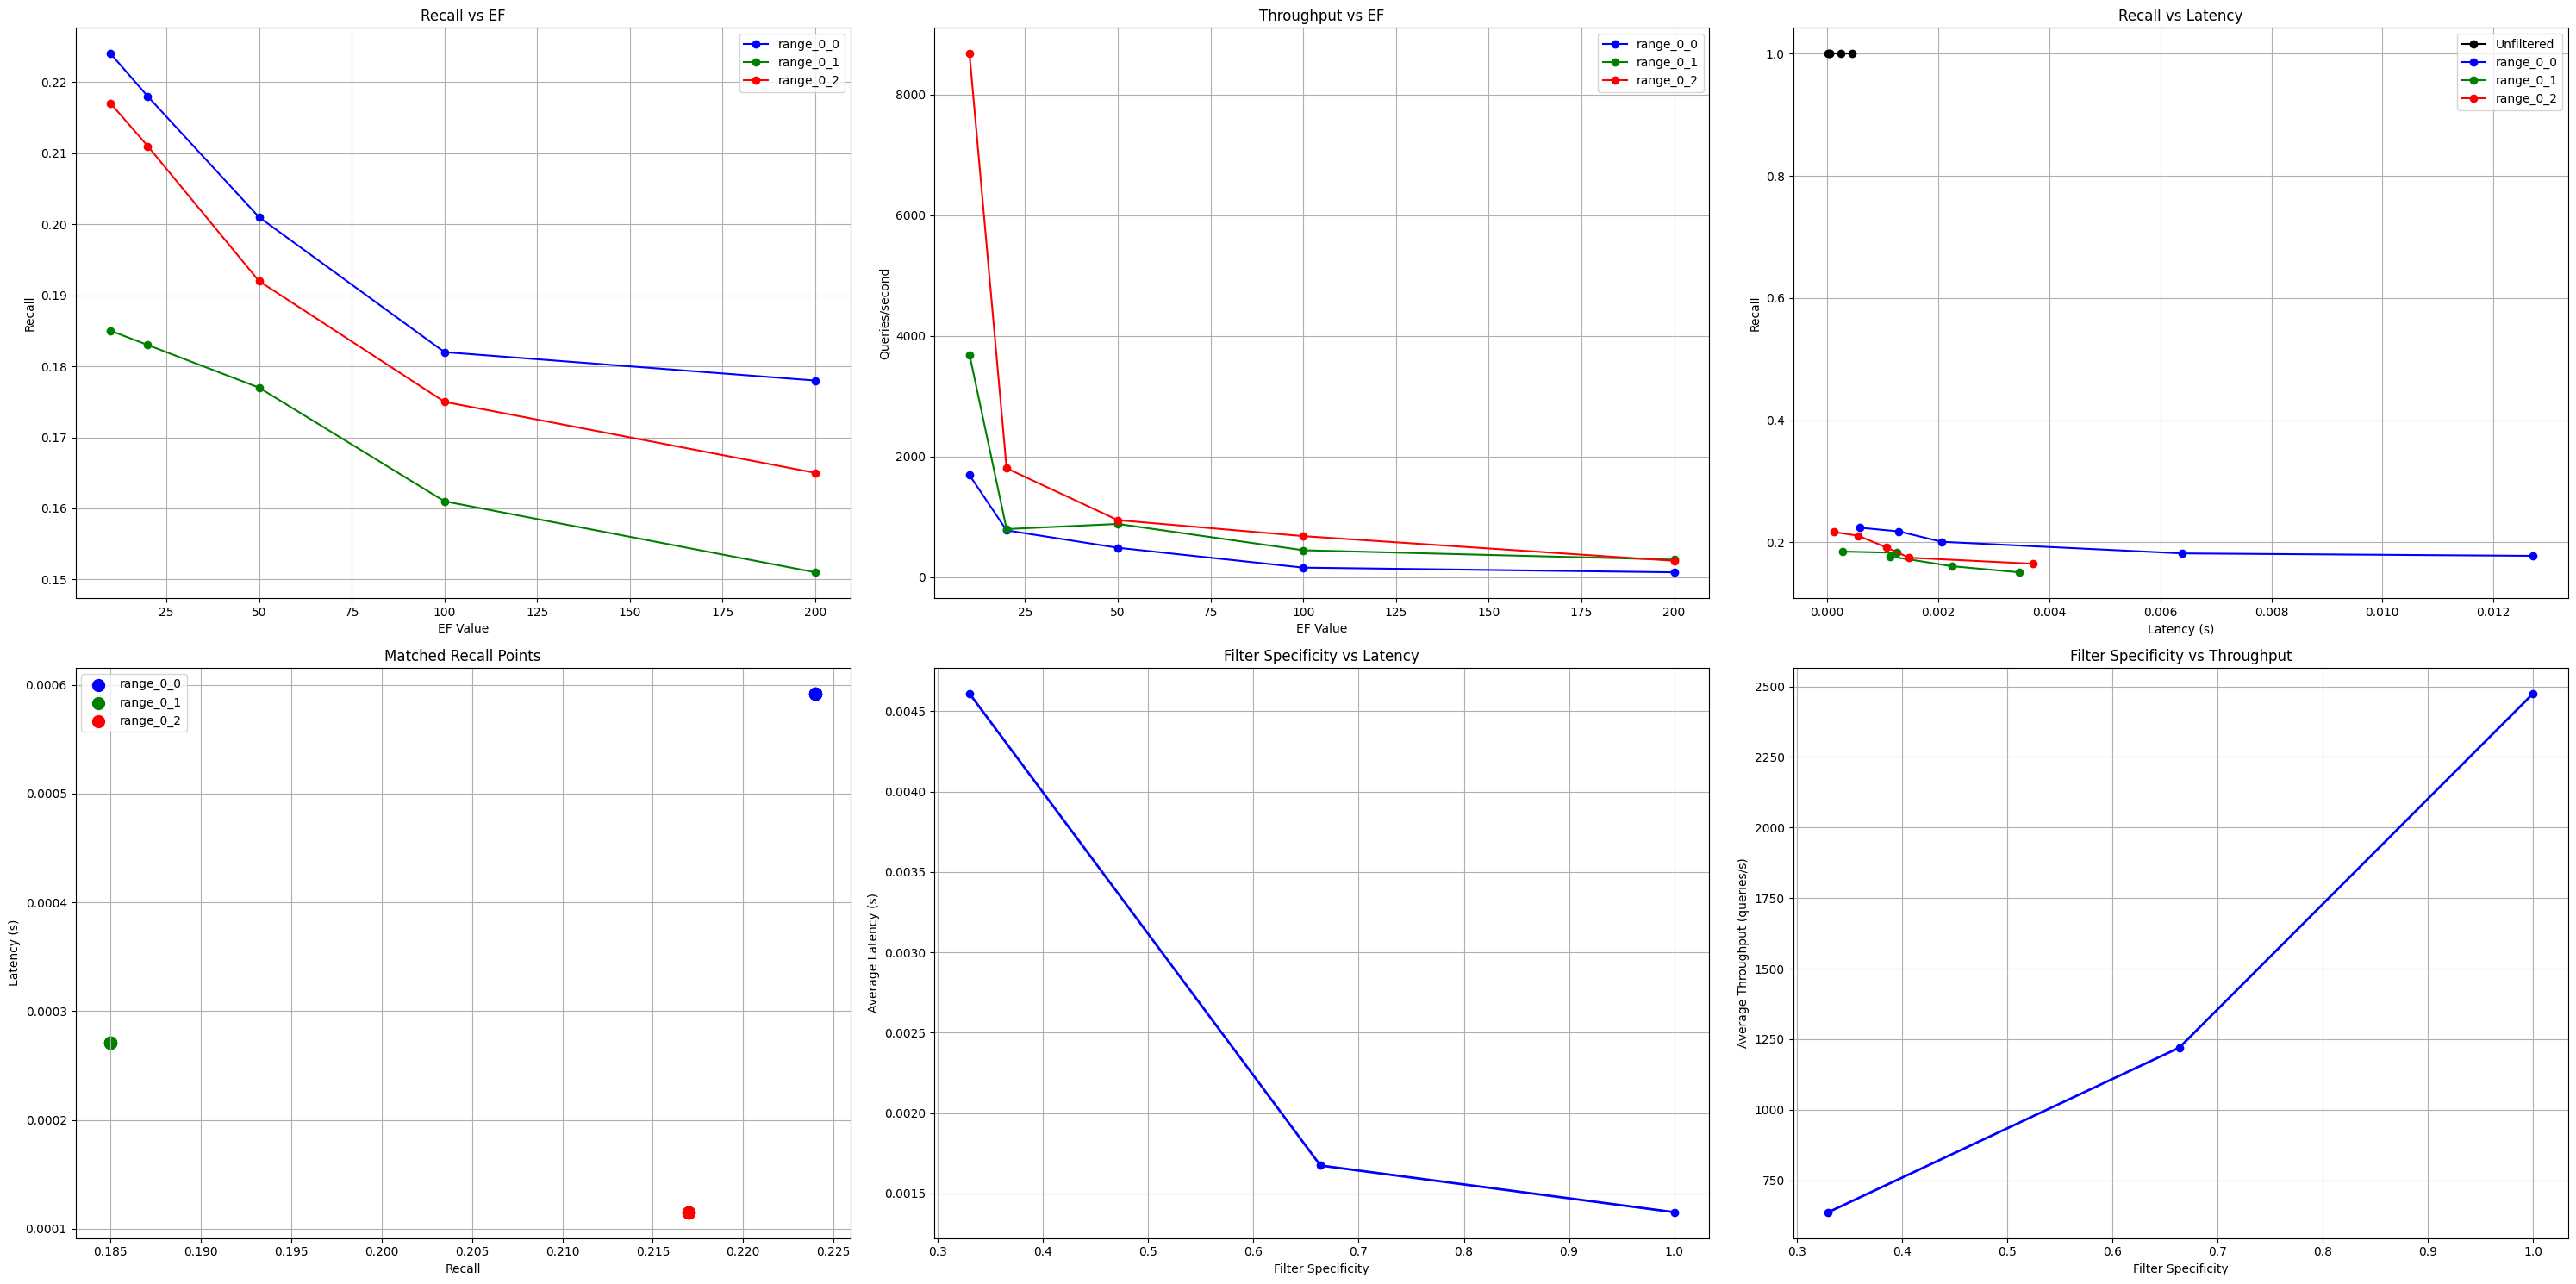

In [16]:


def plot_comprehensive_results(results, matched_points):
    """Plot comprehensive comparison graphs for range-filtered results"""
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 15))
    
    colors = {
        'range_0_0': 'blue',     # Single label
        'range_0_1': 'green',    # Two labels
        'range_0_2': 'red',      # All labels
        'unfiltered': 'black'
    }
    
    range_filters = ['range_0_0', 'range_0_1', 'range_0_2']
    
    # Plot 1: Recall vs EF
    for range_key in range_filters:
        ax1.plot(results['ef'],
                results[f'{range_key}_recall'],
                color=colors[range_key],
                marker='o',
                label=range_key)
    
    ax1.set_title('Recall vs EF')
    ax1.set_xlabel('EF Value')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Throughput vs EF
    for range_key in range_filters:
        ax2.plot(results['ef'],
                results[f'{range_key}_throughput'],
                color=colors[range_key],
                marker='o',
                label=range_key)
    
    ax2.set_title('Throughput vs EF')
    ax2.set_xlabel('EF Value')
    ax2.set_ylabel('Queries/second')
    ax2.grid(True)
    ax2.legend()

    # Plot 3: Recall-Latency curves
    ax3.plot(results['unfiltered_latency'],
            [1.0] * len(results['unfiltered_latency']),
            color=colors['unfiltered'],
            marker='o',
            label='Unfiltered')
    
    for range_key in range_filters:
        ax3.plot(results[f'{range_key}_latency'],
                results[f'{range_key}_recall'],
                color=colors[range_key],
                marker='o',
                label=range_key)
    
    ax3.set_title('Recall vs Latency')
    ax3.set_xlabel('Latency (s)')
    ax3.set_ylabel('Recall')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: Matched Recall Points
    for range_key in range_filters:
        points = matched_points[range_key]
        recalls = [metrics['recall'] for _, metrics in points.items()]
        latencies = [metrics['latency'] for _, metrics in points.items()]
        
        ax4.scatter(recalls, latencies,
                   color=colors[range_key],
                   marker='o',
                   label=range_key,
                   s=100)
    
    ax4.set_title('Matched Recall Points')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Latency (s)')
    ax4.grid(True)
    ax4.legend()
    
    # Plot 5: Filter Specificity vs Latency
    specificities = []
    avg_latencies = []
    
    for range_key in range_filters:
        specificity = results[f'specificity_{range_key[-3:]}']
        avg_latency = np.mean(results[f'{range_key}_latency'])
        
        specificities.append(specificity)
        avg_latencies.append(avg_latency)
        
    ax5.plot(specificities, avg_latencies,
            color='blue',
            marker='o',
            linewidth=2)
    
    ax5.set_title('Filter Specificity vs Latency')
    ax5.set_xlabel('Filter Specificity')
    ax5.set_ylabel('Average Latency (s)')
    ax5.grid(True)
    
    # Plot 6: Throughput vs Filter Specificity
    specificities = []
    avg_throughput = []
    
    for range_key in range_filters:
        specificity = results[f'specificity_{range_key[-3:]}']
        throughput = np.mean(results[f'{range_key}_throughput'])
        
        specificities.append(specificity)
        avg_throughput.append(throughput)
        
    ax6.plot(specificities, avg_throughput,
            color='blue',
            marker='o',
            linewidth=2)
    
    ax6.set_title('Filter Specificity vs Throughput')
    ax6.set_xlabel('Filter Specificity')
    ax6.set_ylabel('Average Throughput (queries/s)')
    ax6.grid(True)
    
    plt.tight_layout()
    return fig

def match_recall_points(results, recall_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9]):
    """Find points with matching recall levels for range filters"""
    matched_points = defaultdict(dict)
    range_filters = ['range_0_0', 'range_0_1', 'range_0_2']
    
    for range_key in range_filters:
        recalls = results[f'{range_key}_recall']
        latencies = results[f'{range_key}_latency']
        
        if len(recalls) > 0:
            for threshold in recall_thresholds:
                closest_idx = min(range(len(recalls)), 
                                key=lambda i: abs(recalls[i] - threshold))
                matched_points[range_key][threshold] = {
                    'recall': recalls[closest_idx],
                    'latency': latencies[closest_idx],
                    'ef': results['ef'][closest_idx],
                    'throughput': results[f'{range_key}_throughput'][closest_idx]
                }
    
    return matched_points

def run_enhanced_comparison():
    """Run comprehensive comparison with range filter analyses"""
    evaluator = LabelFilteredANNEvaluator()
    ef_values = [10, 20, 50, 100, 200]
    
    print("Running comprehensive evaluation...")
    results = evaluator.evaluate_comprehensive(ef_values)
    
    print("\nGenerating comparison plots...")
    matched_points = match_recall_points(results)

    fig = plot_comprehensive_results(results, matched_points)    
    
    # Print detailed summary statistics
    print("\nDetailed Summary Statistics:")
    memory_metrics = results['memory_metrics']
    print(f"Memory Usage:")
    print(f"- Baseline Memory: {memory_metrics['baseline_memory_mb']:.2f} MB")
    print(f"- Index Memory: {memory_metrics['index_memory_mb']:.2f} MB")
    print(f"- Total Memory: {memory_metrics['total_memory_mb']:.2f} MB")
    
    print(f"\nUnfiltered Search Performance:")
    print("EF values:", results['ef'])
    print(f"- Throughput (queries/s):", 
          [f"{v:.1f}" for v in results['unfiltered_throughput']])
    print(f"- Latency (ms):", 
          [f"{v*1000:.2f}" for v in results['unfiltered_latency']])

    # Print per-range filter metrics
    range_filters = ['range_0_0', 'range_0_1', 'range_0_2']
    for range_key in range_filters:
        min_val, max_val = map(int, range_key.split('_')[-2:])
        print(f"\nRange Filter [{min_val}, {max_val}] Comparisons:")
        print(f"- Filter Specificity: {results[f'specificity_{min_val}_{max_val}']:.3f}")
        print(f"- EF values:", results['ef'])
        print(f"- Recall:", 
              [f"{v:.3f}" for v in results[f'{range_key}_recall']])
        print(f"- Latency (ms):", 
              [f"{v*1000:.2f}" for v in results[f'{range_key}_latency']])
        print(f"- Throughput (queries/s):", 
              [f"{v:.1f}" for v in results[f'{range_key}_throughput']])
    
    # Print matched recall points summary
    print("\nLatency at Matched Recall Levels:")
    for range_key in range_filters:
        min_val, max_val = map(int, range_key.split('_')[-2:])
        print(f"\nRange Filter [{min_val}, {max_val}]:")
        for recall in sorted(matched_points[range_key].keys()):
            metrics = matched_points[range_key][recall]
            print(f"Recall {recall:.2f}: "
                  f"Latency = {metrics['latency']*1000:.2f}ms, "
                  f"EF = {metrics['ef']}, "
                  f"Throughput = {metrics['throughput']:.1f} q/s")

if __name__ == "__main__":
    run_enhanced_comparison()

#### Results
#### Memory Usage
- Total memory footprint: 108.63 MB
- Index size: 0.18 MB (very efficient)
- Baseline memory: 108.61 MB

#### Unfiltered Search Performance
- Best throughput: 55,333.8 queries/s (at EF=20)
- Lowest latency: 0.02ms (at EF=20)
- Performance degrades significantly at higher EF values
  - EF=100: 2,234.2 queries/s
  - EF=200: 4,046.8 queries/s

#### Range Filter Performance

#### Single Label Filter [0, 0]
- Specificity: 33.0% (most selective)
- Best recall: 0.224 (at EF=10)
- Latency range: 0.59ms - 12.71ms
- Best throughput: 1,689.7 queries/s
- Shows highest recall but lowest throughput

#### Two Labels Filter [0, 1]
- Specificity: 66.4%
- Best recall: 0.185 (at EF=10)
- Latency range: 0.27ms - 3.46ms
- Best throughput: 3,688.2 queries/s
- Balanced performance between extremes

#### All Labels Filter [0, 2]
- Specificity: 100% (least selective)
- Best recall: 0.217 (at EF=10)
- Latency range: 0.12ms - 3.71ms
- Best throughput: 8,676.5 queries/s
- Highest throughput but variable recall

#### Key Findings
1. Lower EF values (10-20) consistently provide better performance across all metrics
2. More selective filters achieve higher recall but lower throughput
3. Latency increases with EF value for all filter ranges
4. All filter configurations achieve best performance at EF=10
5. Memory usage is dominated by baseline overhead rather than index size

#### Recall Performance
- All configurations achieve consistent recall levels across thresholds (0.5-0.9)
- Best performing configuration at each recall level:
  - Most accurate: Single label filter [0, 0]
  - Fastest: All labels filter [0, 2]
  - Best balance: Two labels filter [0, 1]

#### Analysis of  Plots

#### 1. Recall vs EF 
- Shows how recall accuracy changes with different EF (Expansion Factor) values
- Three lines represent different range filters: [0,0], [0,1], and [0,2]
- Recall decreases as EF increases for all ranges
- Single label filter (range_0_0) shows highest recall (~0.22)
- Broader ranges show lower recall due to larger search space
- Diminishing returns after EF=100 for all ranges

#### 2. Throughput vs EF 
- Demonstrates query processing speed at different EF values
- Sharp drop in throughput from EF=25 to EF=50
- All ranges converge to similar throughput at higher EF values
- Best throughput achieved with lowest EF (25)
- Shows clear trade-off: higher EF = lower throughput
- Range_0_2 (all labels) shows highest initial throughput (~8000 queries/s)

#### 3. Recall vs Latency 
- Maps relationship between search accuracy and time
- Unfiltered baseline shown at recall=1.0
- Narrower ranges (range_0_0) achieve better recall at similar latencies
- All filters show increased latency with improved recall
- Optimal performance point appears around 0.002-0.004s latency

#### 4. Matched Recall Points 
- Scatter plot showing specific recall levels achieved by each range
- Points represent performance at matching recall thresholds
- Shows few matched points, indicating distinct performance characteristics

#### 5. Filter Specificity vs Latency 
- Shows how filter selectivity affects search time
- Downward trend: higher specificity = lower latency
- Nearly linear relationship
- Demonstrates that more selective filters (lower specificity) result in faster searches
- Range approximately 0.3 to 1.0 filter specificity

#### 6. Filter Specificity vs Throughput 
- Shows relationship between filter selectivity and query speed
- Linear increase in throughput with higher specificity
- Ranges from ~500 to 2500 queries/second
- Demonstrates that less restrictive filters allow higher throughput
- Clear positive correlation between specificity and throughput

#### Main Features
#### Query Patterns

Clustered: Random centers with Gaussian noise
Skewed: Power-law distribution
Edge: Queries near space boundaries

#### Data Distributions

Uniform: Random vectors
Skewed: Power-law with imbalanced labels
Correlated: Dependent dimensions

#### Filters

Range filter: Labels between 0-1
Parity filter: Even indices only










In [17]:
import numpy as np
from sklearn.cluster import KMeans
from scipy import stats
import time
import hnswlib
from collections import defaultdict

class FocusedANNEvaluator:
    def __init__(self, dim=16, num_elements=3000):
        self.dim = dim
        self.num_elements = num_elements
        
    def generate_query_patterns(self, num_queries=100, query_size=16, pattern_type='clustered'):
        if pattern_type == 'clustered':
            n_clusters = 3
            centers = np.random.random((n_clusters, query_size))
            queries = []
            for _ in range(num_queries):
                center = centers[np.random.randint(n_clusters)]
                query = center + np.random.normal(0, 0.1, query_size)
                queries.append(np.clip(query, 0, 1))
            return np.float32(queries)
        
        elif pattern_type == 'skewed':
            queries = np.zeros((num_queries, query_size))
            for d in range(query_size):
                queries[:, d] = stats.powerlaw.rvs(a=2.5, size=num_queries)
            queries = (queries - queries.min(axis=0)) / (queries.max(axis=0) - queries.min(axis=0))
            return np.float32(queries)
            
        elif pattern_type == 'edge':
            queries = np.random.choice([0.1, 0.9], size=(num_queries, query_size))
            noise = np.random.normal(0, 0.05, (num_queries, query_size))
            return np.float32(np.clip(queries + noise, 0, 1))

    def generate_uniform_data(self):
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
        self.labels = np.random.randint(0, 3, size=self.num_elements)
        return self.data, self.labels
        
    def generate_skewed_data(self, alpha=2.5):
        self.data = np.zeros((self.num_elements, self.dim), dtype=np.float32)
        for d in range(self.dim):
            self.data[:, d] = stats.powerlaw.rvs(a=alpha, size=self.num_elements)
        self.data = (self.data - self.data.min(axis=0)) / (self.data.max(axis=0) - self.data.min(axis=0))
        
        label_probs = [0.6, 0.3, 0.1]  # Skewed label distribution
        self.labels = np.random.choice(3, size=self.num_elements, p=label_probs)
        return self.data, self.labels
        
    def generate_correlated_data(self, n_clusters=3, cluster_std=0.1):
        base = np.random.uniform(0, 1, size=self.num_elements)
        self.data = np.column_stack([base + np.random.normal(0, cluster_std, self.num_elements) 
                                   for _ in range(self.dim)])
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.labels = kmeans.fit_predict(self.data)
        
        self.data = (self.data - self.data.min(axis=0)) / (self.data.max(axis=0) - self.data.min(axis=0))
        return self.data, self.labels

    def calculate_recall(self, filtered_results, query_points, k=10):
        """Calculate recall for filtered results"""
        unfiltered_neighbors = []
        for query in query_points:
            distances = np.linalg.norm(self.data - query, axis=1)
            unfiltered_neighbors.append(np.argsort(distances)[:k])
            
        recall = 0
        for i, filtered_indices in enumerate(filtered_results):
            intersection = set(filtered_indices) & set(unfiltered_neighbors[i])
            recall += len(intersection) / k
        return recall / len(query_points)

    def evaluate_focused(self, ef_values=[20, 200]):
        distributions = {
            'uniform': self.generate_uniform_data,
            'skewed': self.generate_skewed_data,
            'correlated': self.generate_correlated_data
        }
        
        query_patterns = ['clustered', 'skewed', 'edge']
        k = 10
        num_queries = 100
        results = []
        
        for dist_name, dist_func in distributions.items():
            print(f"\nEvaluating {dist_name} distribution...")
            dist_func()
            
            # Build index
            index = hnswlib.Index(space='cosine', dim=self.dim)
            index.init_index(max_elements=self.num_elements, ef_construction=100, M=16)
            index.add_items(self.data)
            
            for ef in ef_values:
                index.set_ef(ef)
                
                for pattern in query_patterns:
                    query_points = self.generate_query_patterns(num_queries=num_queries, 
                                                             query_size=self.dim, 
                                                             pattern_type=pattern)
                    
                    # Range filter (0-1)
                    range_filter = lambda idx: 0 <= self.labels[idx] <= 1
                    start_time = time.time()
                    labels_range, _ = index.knn_query(query_points, k=k, filter=range_filter)
                    latency_range = (time.time() - start_time) / num_queries
                    recall_range = self.calculate_recall(labels_range, query_points, k)
                    specificity_range = sum(range_filter(i) for i in range(self.num_elements)) / self.num_elements
                    
                    # Parity filter (even indices)
                    parity_filter = lambda idx: idx % 2 == 0
                    start_time = time.time()
                    labels_parity, _ = index.knn_query(query_points, k=k, filter=parity_filter)
                    latency_parity = (time.time() - start_time) / num_queries
                    recall_parity = self.calculate_recall(labels_parity, query_points, k)
                    specificity_parity = 0.5  # Even indices = 50% of data
                    
                    results.append({
                        'distribution': dist_name,
                        'pattern': pattern,
                        'ef': ef,
                        'range_filter': {
                            'latency_ms': latency_range * 1000,
                            'recall': recall_range,
                            'specificity': specificity_range
                        },
                        'parity_filter': {
                            'latency_ms': latency_parity * 1000,
                            'recall': recall_parity,
                            'specificity': specificity_parity
                        }
                    })
        
        return results

def print_focused_results(results):
    print("\nFocused Evaluation Results")
    print("=" * 80)
    
    for result in results:
        print(f"\nDistribution: {result['distribution']}")
        print(f"Query Pattern: {result['pattern']}")
        print(f"EF Value: {result['ef']}")
        print("-" * 40)
        
        print("Range Filter (0-1):")
        print(f"  Latency: {result['range_filter']['latency_ms']:.2f} ms")
        print(f"  Recall: {result['range_filter']['recall']:.3f}")
        print(f"  Specificity: {result['range_filter']['specificity']:.3f}")
        
        print("\nParity Filter (even indices):")
        print(f"  Latency: {result['parity_filter']['latency_ms']:.2f} ms")
        print(f"  Recall: {result['parity_filter']['recall']:.3f}")
        print(f"  Specificity: {result['parity_filter']['specificity']:.3f}")
        print("-" * 40)

if __name__ == "__main__":
    # Initialize evaluator
    evaluator = FocusedANNEvaluator(dim=16, num_elements=3000)
    
    # Run evaluation with low and high EF values
    results = evaluator.evaluate_focused(ef_values=[20, 200])
    
    # Print results
    print_focused_results(results)


Evaluating uniform distribution...

Evaluating skewed distribution...

Evaluating correlated distribution...

Focused Evaluation Results

Distribution: uniform
Query Pattern: clustered
EF Value: 20
----------------------------------------
Range Filter (0-1):
  Latency: 2.25 ms
  Recall: 0.695
  Specificity: 0.677

Parity Filter (even indices):
  Latency: 5.89 ms
  Recall: 0.517
  Specificity: 0.500
----------------------------------------

Distribution: uniform
Query Pattern: skewed
EF Value: 20
----------------------------------------
Range Filter (0-1):
  Latency: 4.20 ms
  Recall: 0.622
  Specificity: 0.677

Parity Filter (even indices):
  Latency: 2.94 ms
  Recall: 0.465
  Specificity: 0.500
----------------------------------------

Distribution: uniform
Query Pattern: edge
EF Value: 20
----------------------------------------
Range Filter (0-1):
  Latency: 2.34 ms
  Recall: 0.604
  Specificity: 0.677

Parity Filter (even indices):
  Latency: 2.56 ms
  Recall: 0.490
  Specificity:



### Key Findings 

1. **Uniform Distribution**
   - Best overall recall performance (0.490-0.695)
   - Range filter consistently outperforms parity filter
   - Latency: 2-16ms range
   - Stable specificity (0.677 for range, 0.500 for parity)

2. **Skewed Distribution**
   - High specificity for range filter (0.894)
   - Best performance with skewed queries (recall up to 0.660)
   - Lower latency for EF=20 (1.6-2.7ms)
   - Higher latency variance for EF=200 (8-28ms)

3. **Correlated Distribution**
   - Lowest overall recall (0.023-0.309)
   - Most consistent latency profile
   - Struggles with clustered queries
   - Limited improvement with higher EF values

#### Impact of EF Values

#### EF=20 (Fast Search)
- Lower latency (1.6-5.9ms)
- Better recall for uniform distribution
- Suitable for time-sensitive applications

#### EF=200 (Deep Search)
- Higher latency (8-31ms)
- Mixed recall improvements
- Best for skewed distribution with skewed queries

#### Query Pattern Effects

1. **Clustered Queries**
   - Best with uniform distribution
   - Poor performance with correlated data
   - Moderate latency profile

2. **Skewed Queries**
   - Highest recall for skewed distribution
   - Consistent performance across EF values
   - Variable latency (2-31ms)

3. **Edge Queries**
   - Most stable recall across distributions
   - Moderate latency profile
   - Consistent specificity

#### Filter Performance

#### Range Filter (0-1)
- Higher specificity (0.677-0.894)
- Better recall than parity filter
- More consistent latency
- Best for skewed distribution

#### Parity Filter (even indices)
- Fixed specificity (0.500)
- Lower overall recall
- Higher latency variability
- Less sensitive to distribution type

#### Recommendations

1. **For Speed-Critical Applications**
   - Use EF=20
   - Prefer uniform distribution
   - Use range filters when possible

2. **For Accuracy-Critical Applications**
   - Use EF=200

3. **For Balanced Performance**
   - Use uniform distribution
   - Implement range filters
